In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        return x.reshape((-1,1,28,28))

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self, latent_dims):
     super(Autoencoder, self).__init__()
     self.encoder = Encoder(latent_dims)
     self.decoder = Decoder(latent_dims)
  def forward(self, x):
    x = self.encoder(x)
    return self.decoder(x)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#Стандартный алгоритм

In [ ]:
autoencoder_1 = train(autoencoder, data, epochs=1)
autoencoder_5 = train(autoencoder, data, epochs=5)
autoencoder_10 = train(autoencoder, data, epochs=10)

100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


In [ ]:
autoencoder_25 = train(autoencoder, data, epochs=25)
autoencoder_50 = train(autoencoder, data, epochs=50)
autoencoder_100 = train(autoencoder, data, epochs=100)

100%|██████████| 100/100 [10:35<00:00,  6.35s/it]


In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

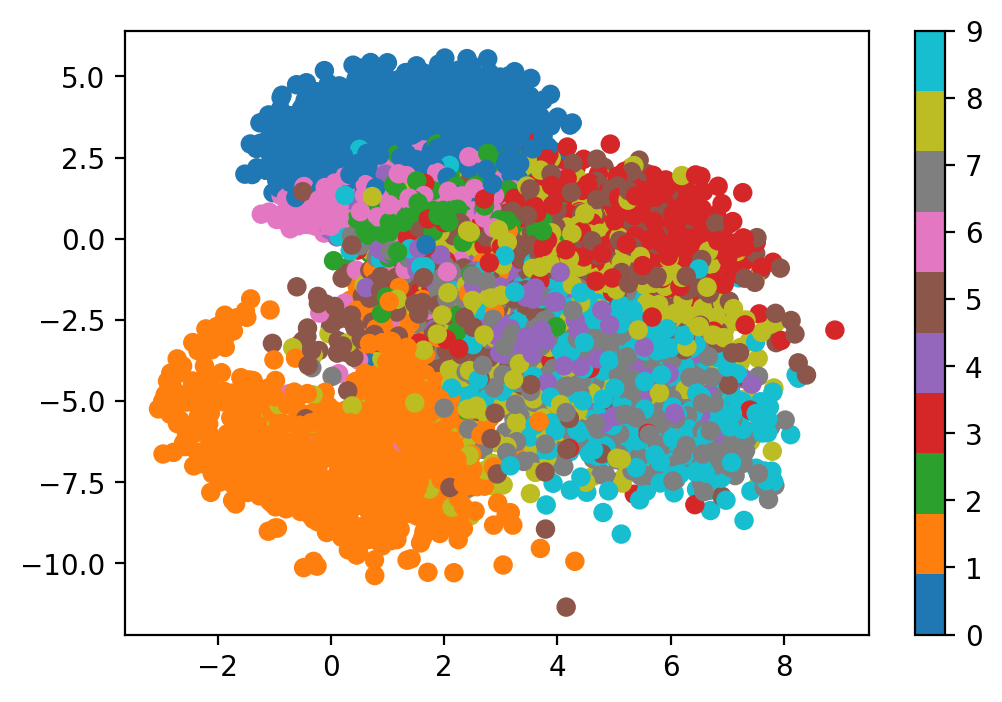

In [ ]:
plot_latent(autoencoder_1, data)

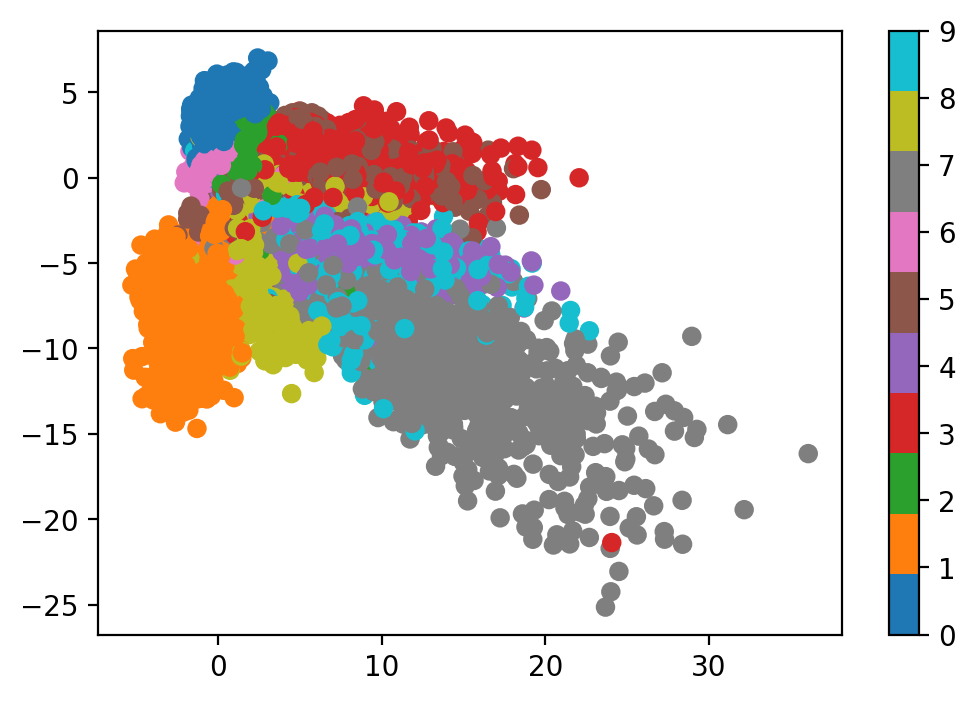

In [ ]:
plot_latent(autoencoder_5, data)

In [ ]:
plot_reconstructed(autoencoder)

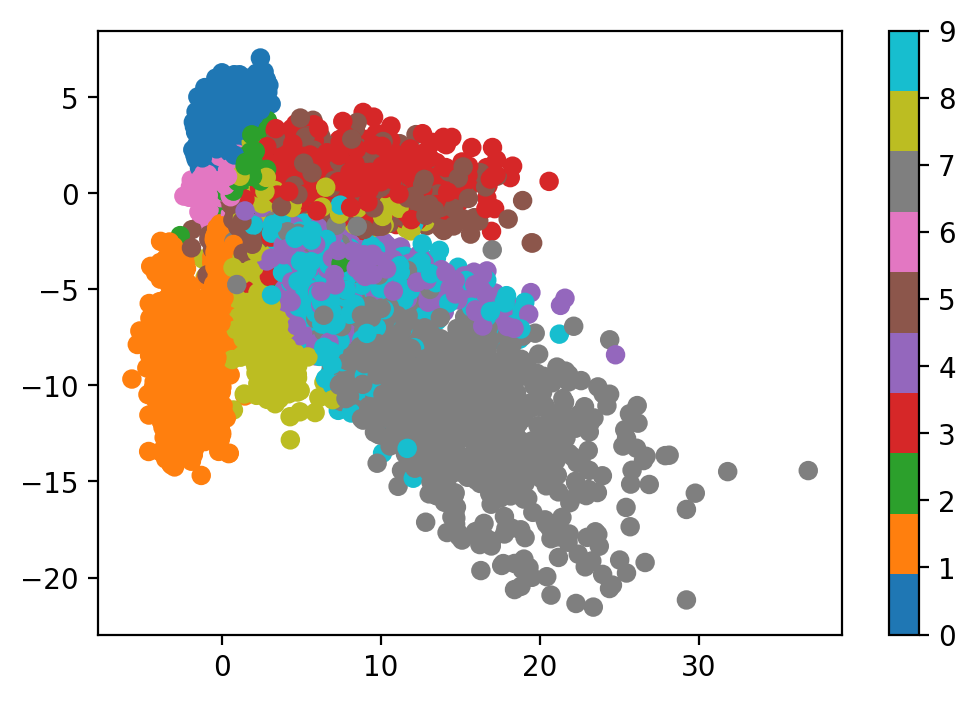

In [ ]:
plot_latent(autoencoder_10, data)

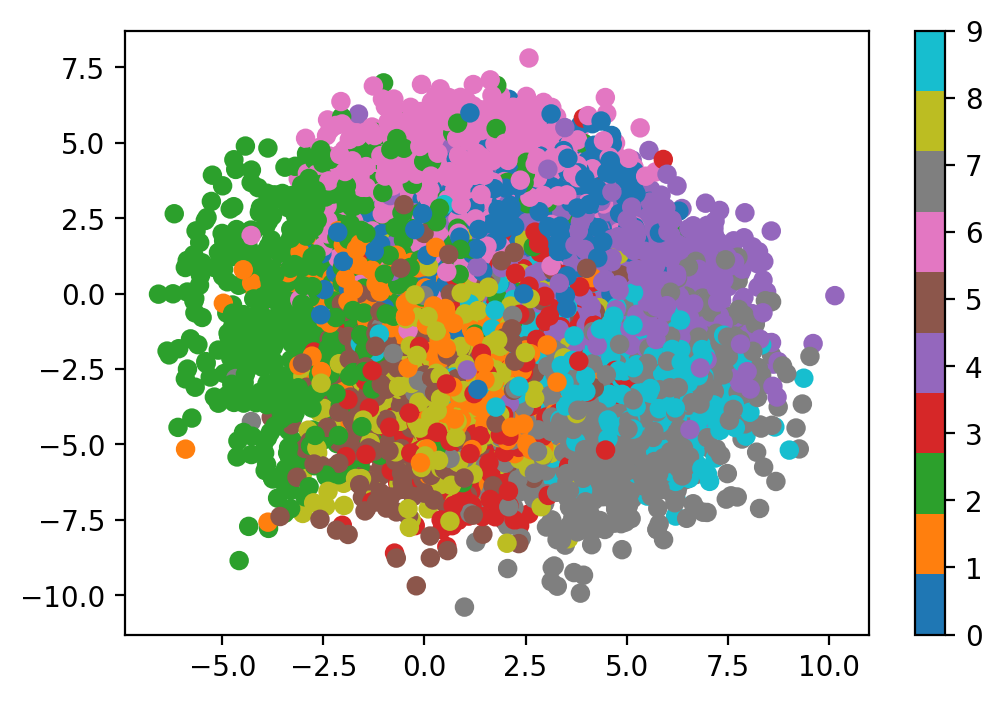

In [ ]:
plot_latent(autoencoder_25, data)

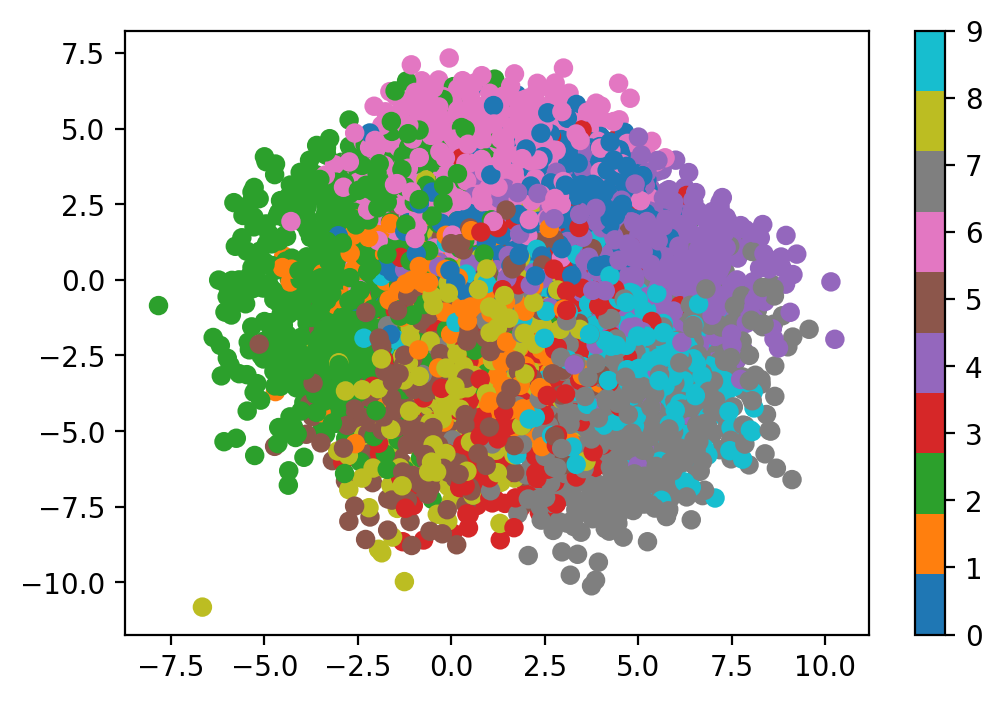

In [ ]:
plot_latent(autoencoder_50, data)

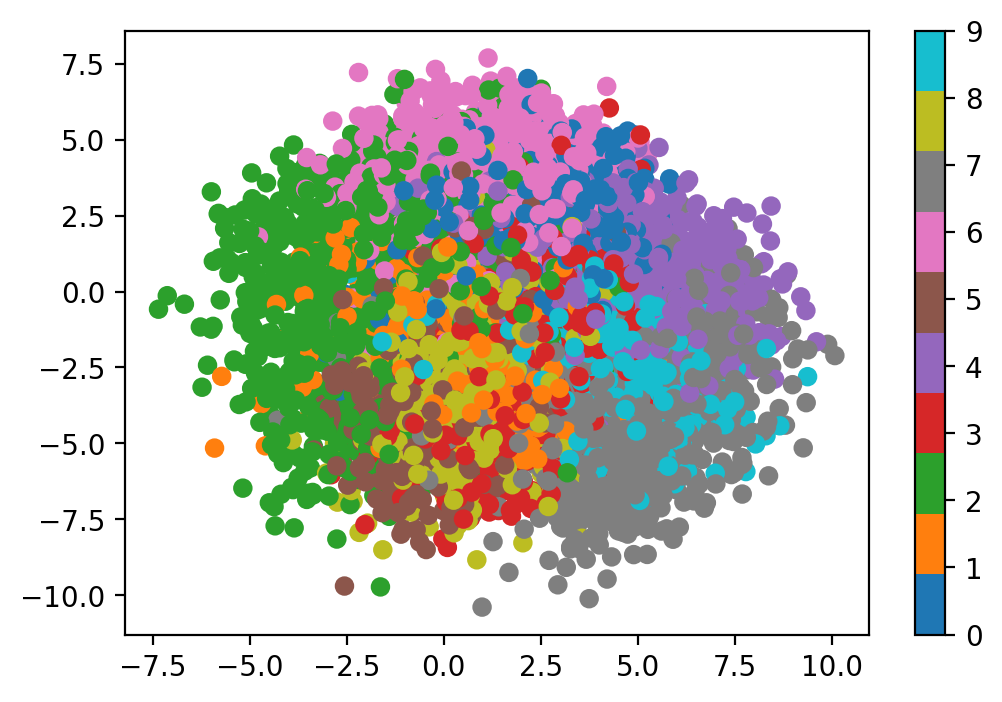

In [ ]:
plot_latent(autoencoder_100, data)

# VAE

In [ ]:
class VariationEncoder(nn.Module):
  def __init__(self, latent_dims):
    super(VariationEncoder, self).__init__()
    self.linear1 = nn.Linear(784, 512)
    self.linear2 = nn.Linear(512, latent_dims)
    self.linear3 = nn.Linear(512, latent_dims)

    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
    self.N.scale = self.N.scale.cuda()
    self.kl = 0
    
  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear1(x))
    mu =  self.linear2(x)
    sigma = torch.exp(self.linear3(x))
    z = mu + sigma*self.N.sample(mu.shape)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z    

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
latent_dims = 2
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae1 = train(vae, data, 1)
vae5 = train(vae, data, 5)
vae10 = train(vae, data, 10)

100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


In [ ]:
vae20 = train(vae, data, 20)
vae50 = train(vae, data, 50)
vae100 = train(vae, data, 100)

100%|██████████| 100/100 [11:57<00:00,  7.17s/it]


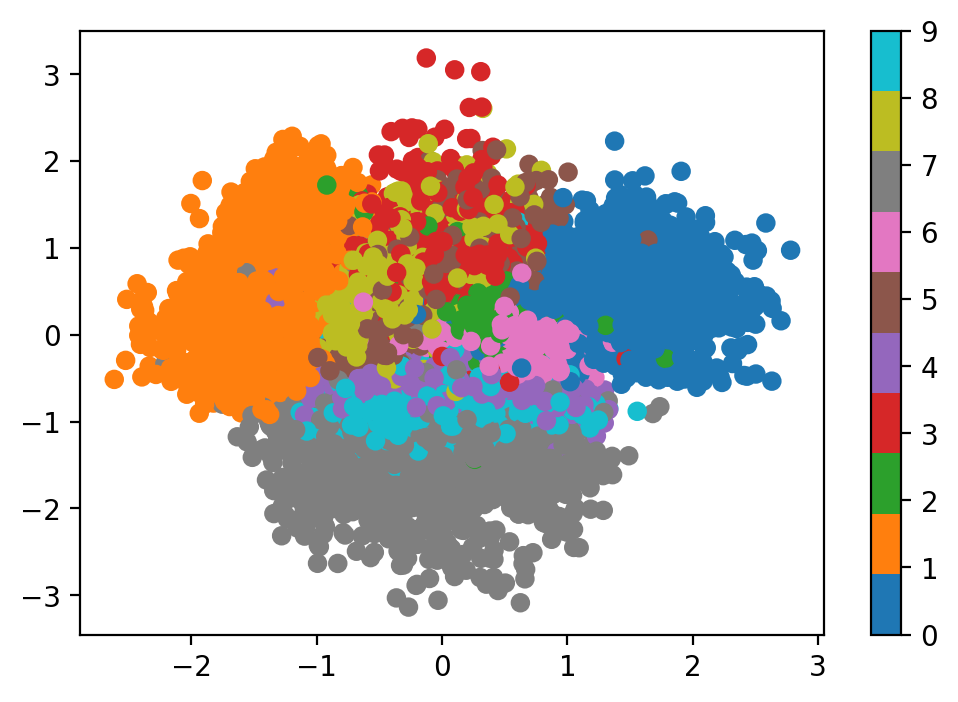

In [ ]:
plot_latent(vae1, data)

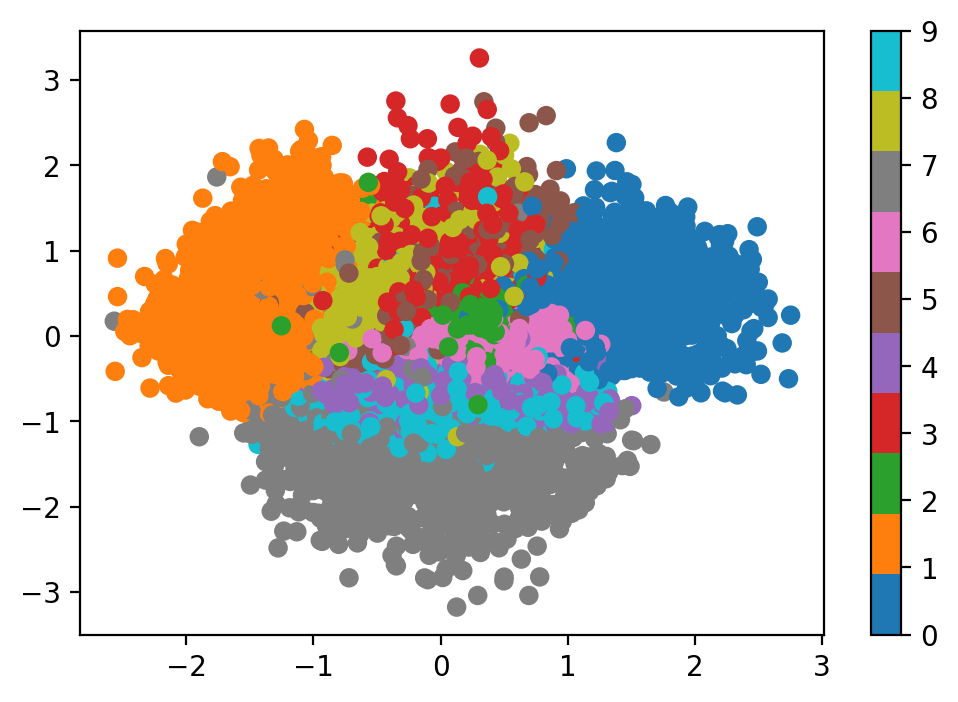

In [ ]:
plot_latent(vae5, data)

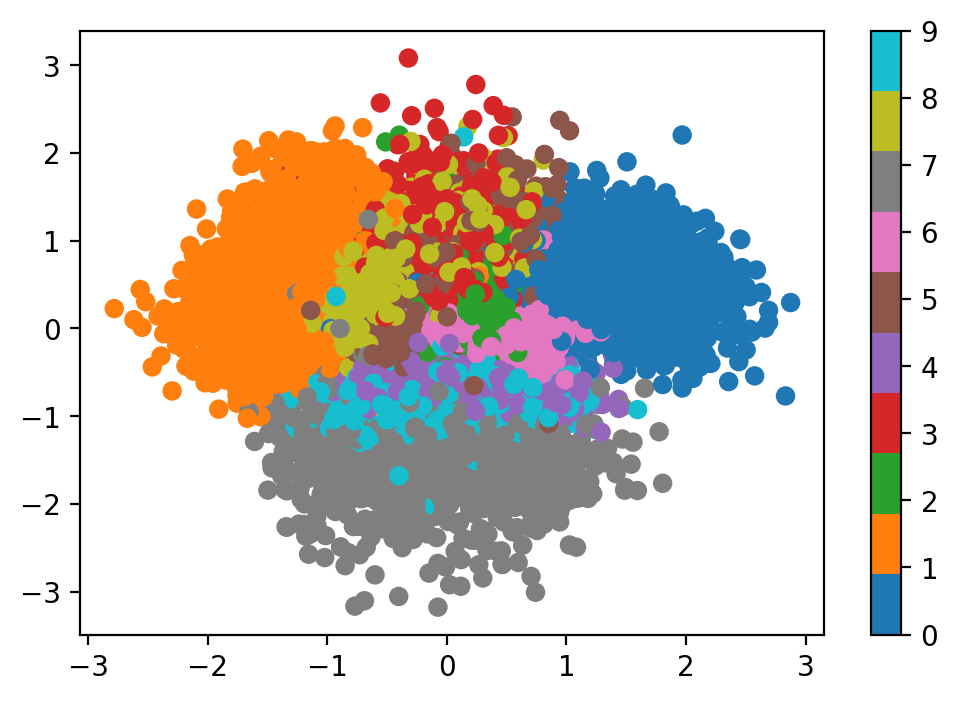

In [ ]:
plot_latent(vae10, data)

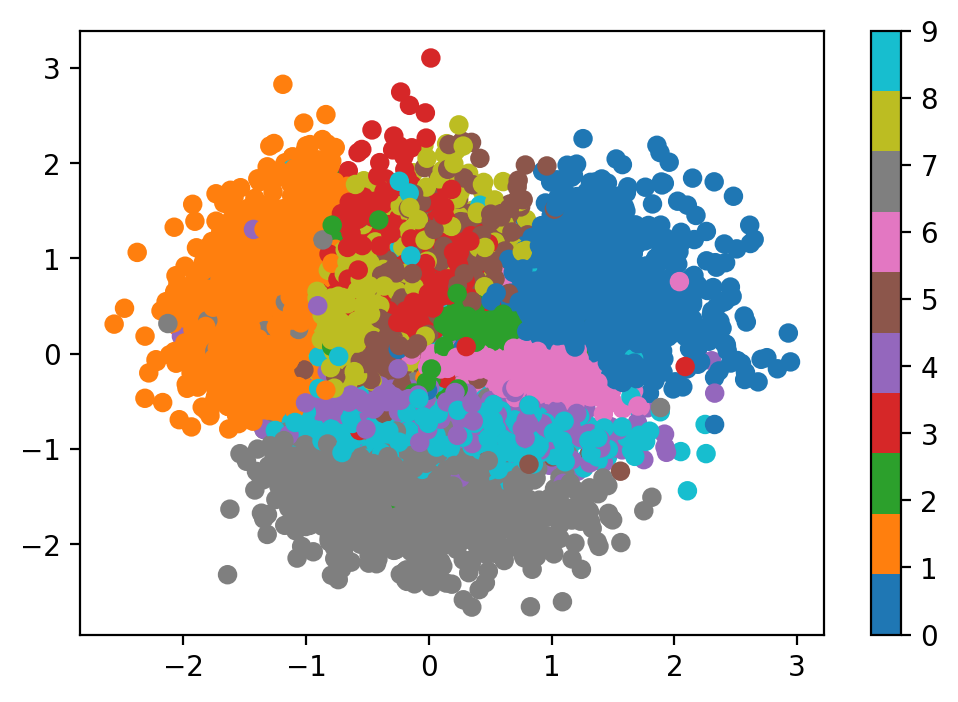

In [ ]:
plot_latent(vae20, data)

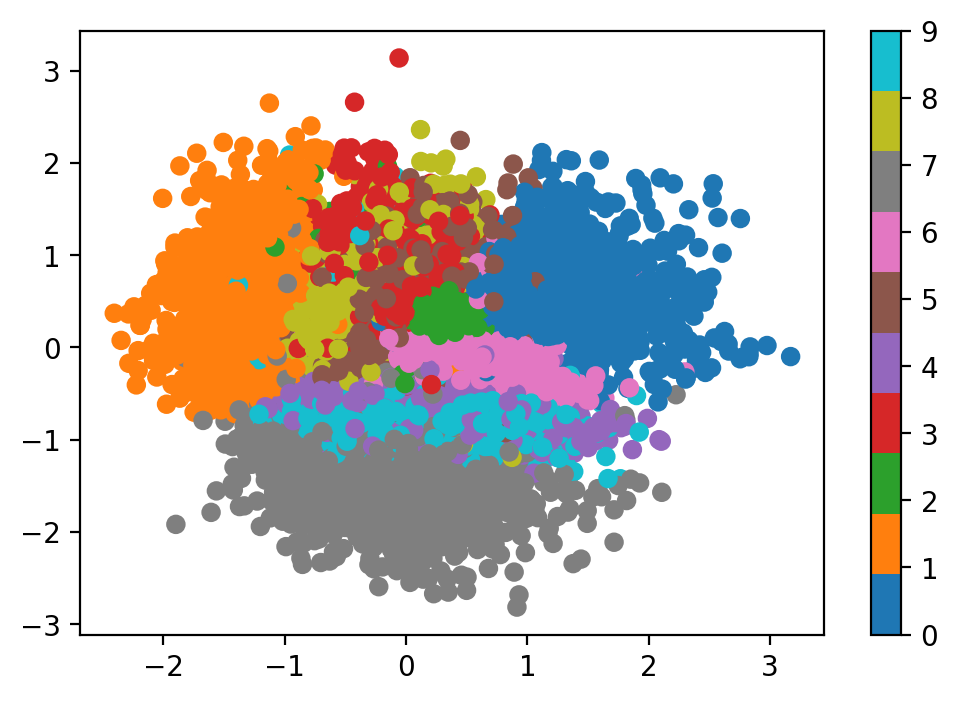

In [ ]:
plot_latent(vae50, data)

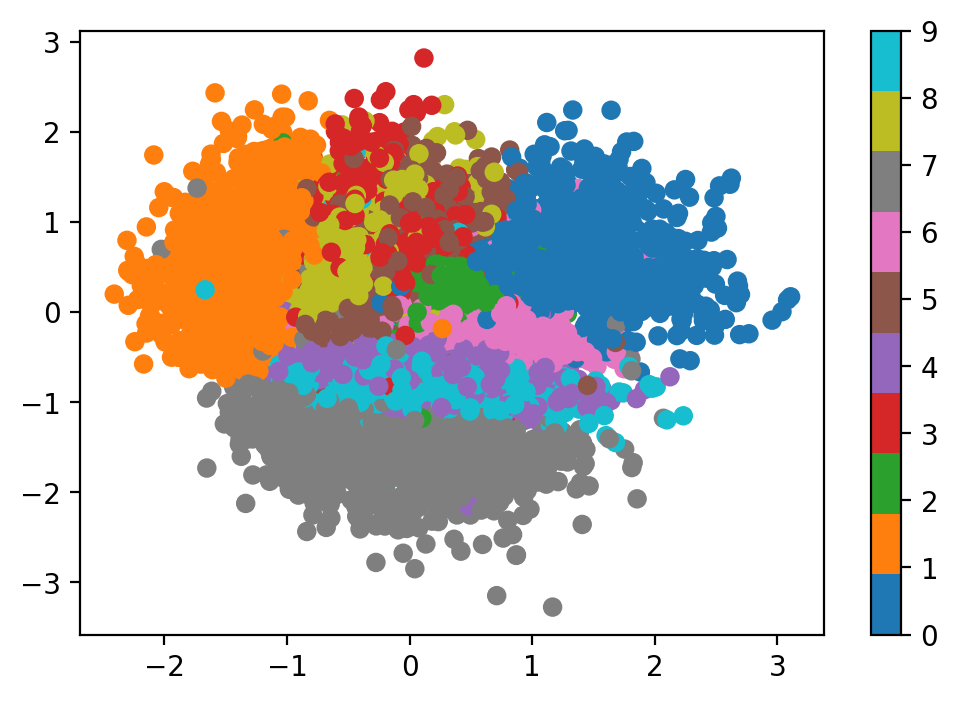

In [ ]:
plot_latent(vae100, data)

# VAE с конволюцией

In [ ]:
class ConvVariationEncoder(nn.Module):
  def __init__(self, latent_dims):
    super(ConvVariationEncoder, self).__init__()
    self.conv = nn.Conv2d(1, 1, 4)
    self.linear1 = nn.Linear(256, 128)
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, latent_dims)
    self.linear4 = nn.Linear(64, latent_dims)

    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
    self.N.scale = self.N.scale.cuda()
    self.kl = 0
    
  def forward(self, x):
    x = F.relu(self.conv(x))
    x = F.relu(self.conv(x))
    x = F.relu(self.conv(x))
    x = F.relu(self.conv(x))
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    mu =  self.linear3(x)
    sigma = torch.exp(self.linear4(x))
    z = mu + sigma*self.N.sample(mu.shape)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z 

In [ ]:
class ConvVariationDecoder(nn.Module):
  def __init__(self, latent_dims):
    super(ConvVariationDecoder, self).__init__()
    self.convTransp = nn.ConvTranspose2d(1,1,4)
    self.linear1 = nn.Linear(latent_dims, 64)
    self.linear2 = nn.Linear(64, 128)
    self.linear3 = nn.Linear(128, 256)
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.relu(self.linear3(x))
    x = torch.sigmoid(x.reshape((-1,1,16,16)))
    x = torch.sigmoid(self.convTransp(x))
    x = torch.sigmoid(self.convTransp(x))
    x = torch.sigmoid(self.convTransp(x))
    x = torch.sigmoid(self.convTransp(x))
    return x

In [ ]:
class ConvVariationAutoEncoder(nn.Module):
  def __init__(self, latent_dims):
    super(ConvVariationAutoEncoder, self).__init__()
    self.encoder = ConvVariationEncoder(latent_dims)
    self.decoder = ConvVariationDecoder(latent_dims)
  def forward(self, x):
    x = self.encoder(x)
    return self.decoder(x)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
latent_dims = 2
cvae = ConvVariationAutoEncoder(latent_dims).to(device) # GPU
cvae1 = train(cvae, data, 1)
cvae10 = train(cvae, data, 10)
cvae20 = train(cvae, data, 20)

100%|██████████| 20/20 [02:49<00:00,  8.48s/it]


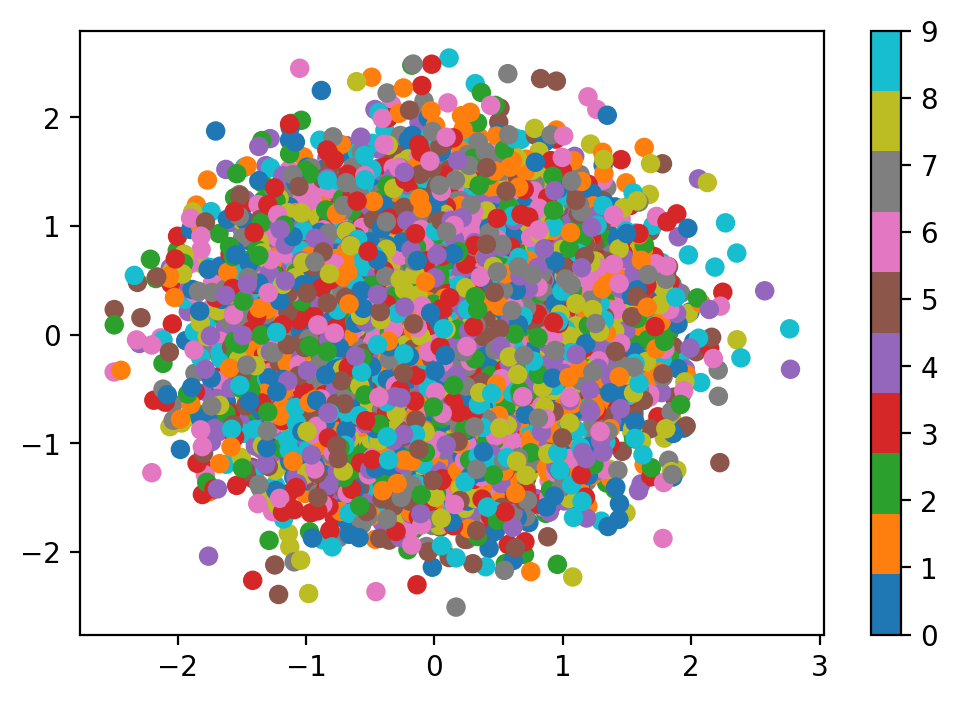

In [ ]:
plot_latent(cvae1, data)

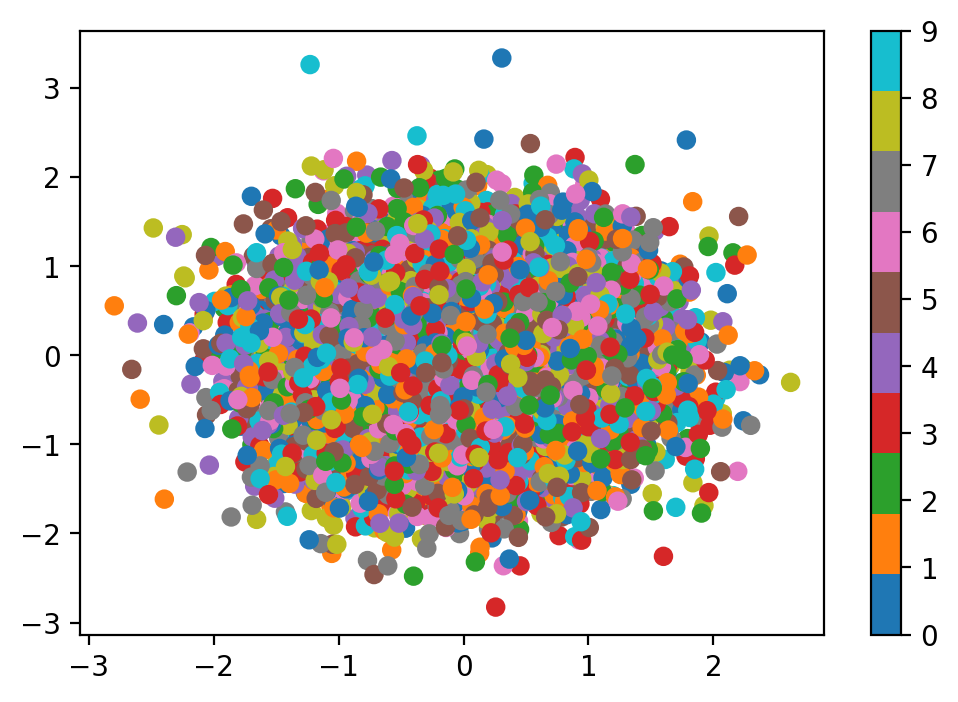

In [ ]:
plot_latent(cvae10, data)

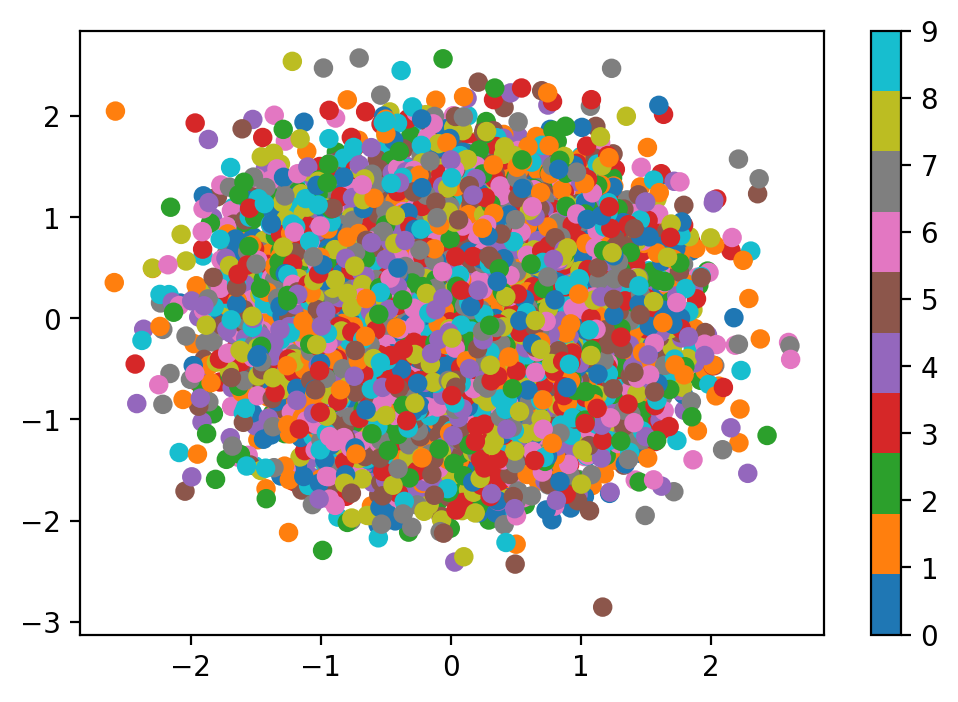

In [ ]:
plot_latent(cvae20, data)

In [ ]:
x, y = next(iter(data)) # hack to grab a batch
x_1 = x[y == 3][0].to(device) # find a 1
x_2 = x[y == 7][0].to(device) 

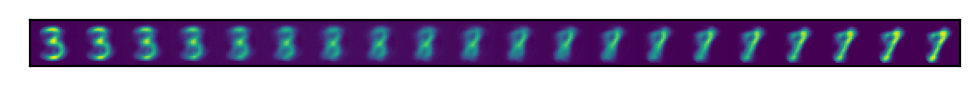

In [ ]:
interpolate(vae, x_1, x_2, n=20)

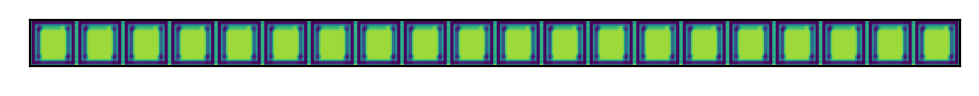

In [ ]:
interpolate(cvae, x_1, x_2, n=20)

In [ ]:
/